In [1]:
# COLAB
!pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"
!pip install mlflow==3.4.0
!pip install iterative-stratification==0.1.9
!pip install simpleitk==2.5.2

In [2]:
# COLAB
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Projets_perso/Projet_IA/TopBrain2025')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="Using a non-tuple sequence for multidimensional indexing is deprecated"
)

In [4]:
# Training parameters
EXPERIMENT_NAME = "unet3d_with_background_in_DiceLoss"
OPTIMIZER_NAME = "SGD_NESTEROV"
LOSS = "(with_bg)DICE/CE(1x)CLDICE(0.3x)"

CHANNELS = (16, 32, 64, 128, 256)
PATCH_SIZE = (128, 128, 128)
NUM_RES_UNITS = 2

N_SPLITS = 5
EPOCHS = 500
BATCH_SIZE = 1
LEARNING_RATE = 1e-2
VAL_INTERVAL = 2
PATIENCE_STOP_LOSS = 20


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
import sys
from tqdm import tqdm
import time
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils.labels_mapping import RelabelByModality
from src.utils.loss import HybridDiceCLDiceLoss
from src.features.utils import BalancedCTMRSampler
from src.features.train_test_split import build_label_presence_matrix

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import monai
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import mlflow

from typing import Dict
import gc

from monai.transforms import (
    Compose,
    MapTransform,
    LoadImaged,
    EnsureChannelFirstd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandAdjustContrastd,
    RandGaussianNoised,
    RandScaleIntensityd,
    AsDiscrete,
    Activations
)
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.inferers import sliding_window_inference

from monai.networks.nets import UNet

# Load data

In [7]:
# Load data
train_data = pd.read_csv('data/processed/train_split.csv')
train_data = train_data.drop(columns=['file_name']).rename(columns={'image_path': 'image', 'label_path': 'label'})
# train_data['image'] = train_data['image'].apply(lambda x: os.path.join('..', x))
# train_data['label'] = train_data['label'].apply(lambda x: os.path.join('..', x))
train_dict = train_data.to_dict('records') # list of dict (one per image) like [{'image':..., 'label':..., 'modality':...}, ...]

In [8]:
matrix = build_label_presence_matrix(train_data, label_path_col='label') # Create the label presence matrix for stratification

mss = MultilabelStratifiedKFold(n_splits=5, random_state=42, shuffle=True) # Define the stratified k-fold cross-validator

# Initialize a dictionary to count the presence of each index in train and val sets across all folds
train_test_idx = {
    'train': np.zeros(38, dtype=int),
    'val': np.zeros(38, dtype=int)
}

for fold, (train_idx, val_idx) in enumerate(mss.split(X=train_data, y=matrix)):
    train_test_idx['train'][train_idx] += 1 # Increment the count for each index in the training set
    train_test_idx['val'][val_idx] += 1 # Increment the count for each index in the validation set

    # Get the training and validation folds
    train_fold = train_data.iloc[train_idx]
    val_fold = train_data.iloc[val_idx]

    print(f"FOLD {fold + 1} - Train fold size: {len(train_fold)}, Val fold size: {len(val_fold)}")
    print(f"MR / CT distribution in train fold:{train_fold['modality'].value_counts().to_dict()}\n")

    # Calculate label presence matrix for the training fold
    train_labels_presence = matrix[train_idx]
    val_labels_presence = matrix[val_idx]

    # Calculate the number of occurrences of each label in the training and validation folds
    num_train_labels_presence = train_labels_presence.sum(axis=0)
    num_val_labels_presence = val_labels_presence.sum(axis=0)

    # Checking if any label is missing in either the training or validation fold
    if 0 in num_train_labels_presence or 0 in num_val_labels_presence:
        print("Warning: Some labels are missing in either the training or validation set. Skipping this fold.\n")

print("-" * 50)
print("\nIdx presence across all folds:")
print(f"Train set idx presence (/{mss.n_splits} Folds):", train_test_idx['train'])
print(f"Validation set idx presence (/{mss.n_splits} Folds):", train_test_idx['val'])

FOLD 1 - Train fold size: 30, Val fold size: 8
MR / CT distribution in train fold:{'ct': 16, 'mr': 14}

FOLD 2 - Train fold size: 30, Val fold size: 8
MR / CT distribution in train fold:{'ct': 16, 'mr': 14}

FOLD 3 - Train fold size: 31, Val fold size: 7
MR / CT distribution in train fold:{'ct': 16, 'mr': 15}

FOLD 4 - Train fold size: 29, Val fold size: 9
MR / CT distribution in train fold:{'ct': 16, 'mr': 13}

FOLD 5 - Train fold size: 32, Val fold size: 6
MR / CT distribution in train fold:{'ct': 16, 'mr': 16}

--------------------------------------------------

Idx presence across all folds:
Train set idx presence (/5 Folds): [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4]
Validation set idx presence (/5 Folds): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]


# Augmentations implementation

In [9]:
class AugmentByModality(MapTransform):
    """Apply different pipelines of augmentations based on image modality."""
    def __init__(self, keys: list, modality_key: str = "modality", pipes:Dict[str, Compose] = None):
        super().__init__(keys)
        self.modality_key = modality_key
        self.pipes = pipes if pipes is not None else {}

    def __call__(self, data: dict) -> dict:
        d = dict(data)

        modality = d.get(self.modality_key, None)
        pipe = self.pipes.get(modality, None)

        if pipe is not None:
            d = pipe(d)

        return d

In [10]:
# Define transforms specific to each modality
cta_transforms = Compose([
    RandAdjustContrastd(keys=['image'], prob=1, gamma=(0.95, 1.10))
])

mra_transforms = Compose([
    RandAdjustContrastd(keys=['image'], prob=1, gamma=(0.8, 1.25)),
    RandScaleIntensityd(keys=['image'], factors=0.1, prob=1)
])

In [11]:
# Define overall training and testing augmentations
train_augmentations = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    RelabelByModality(keys=['label']),
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=PATCH_SIZE,
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0),
    RandAffined(
        keys=['image', 'label'],
        mode=['bilinear', 'nearest'],
        prob=1,
        rotate_range=(0, 0, np.pi/20),
        scale_range=(0.1, 0.1, 0.1),
        translate_range=(5, 5, 5),
        padding_mode='zeros'
    ),
    RandGaussianNoised(
        keys=['image'],
        prob=1,
        mean=0.0,
        std=0.01
    ),
    AugmentByModality(
        keys=['image'],
        pipes={
            'ct': cta_transforms,
            'mr': mra_transforms
        }
    )
])

test_augmentations = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    RelabelByModality(keys=['label'])
])

In [12]:
train_ds = Dataset(data=train_dict, transform=train_augmentations)
train_loader = DataLoader(train_ds, batch_size=1, num_workers=4, sampler=BalancedCTMRSampler(train_ds))

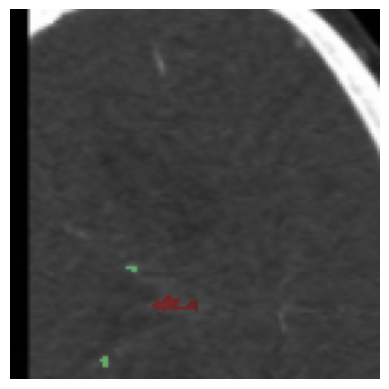

In [13]:
# Test train data loading
batch = next(iter(train_loader))

img_slice = batch['image'][0, :, :, batch['image'].shape[-2]//2, :]
label_slice = batch['label'][0, :, :, batch['label'].shape[-2]//2, :]

# superpose image and label for visualization
img = monai.visualize.blend_images(img_slice, label_slice, alpha=0.5, cmap="jet").permute(1, 2, 0)

plt.imshow(img)
plt.axis('off')
plt.show()

# Create Inference function

In [14]:
def infer_volume(model, inputs, vol_size=(96, 96, 96), sw_patch_size=4, overlap=0.25):
    """Infer a 3D image volume using sliding window inference."""
    model.eval()
    with torch.no_grad():
        return sliding_window_inference(
            inputs = inputs,                    # e.g. a 3D image volume
            roi_size = vol_size,                # size of the sliding window
            sw_batch_size = sw_patch_size,      # number of sliding windows to process in parallel
            predictor = model,                  # the model to run
            overlap = overlap                   # amount of overlap between sliding windows
        )

# Calculate Labels weights

In [15]:
def calculate_weights(train_data:pd.DataFrame, class_nb:int) -> torch.Tensor:
    """Compute class weights based on the frequency of each label in the training data."""
    counter = [0 for i in range(class_nb)] # 0-48 labels
    remap = RelabelByModality('label')
    for p, modality in zip(train_data['label'], train_data['modality']):
        label_nii = nib.load(p)
        label_data = label_nii.get_fdata()
        label_data = remap({'label': label_data, 'modality': modality})['label']
        unique, counts = np.unique(label_data, return_counts=True)
        for u, c in zip(unique, counts):
            counter[int(u)] += c

    weights = torch.tensor(counter)
    weights = 1 / (weights + 1e-6) # inverse frequency
    weights = weights / weights.sum() # normalize to sum to 1
    weights = weights * class_nb  # scale to have mean of 1
    return weights

weights = calculate_weights(train_data, class_nb=49)

# CV Training

In [16]:
filename = f"models/{EXPERIMENT_NAME}/config.txt"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, "w") as f:
    f.write(f"Experiment name: {EXPERIMENT_NAME}\n")
    f.write(f"Optimizer: {OPTIMIZER_NAME}\n")
    f.write(f"Loss function: {LOSS}\n")
    f.write(f"Channels: {CHANNELS}\n")
    f.write(f"Patch size: {PATCH_SIZE}\n")
    f.write(f"Number of residual units: {NUM_RES_UNITS}\n")
    f.write(f"Learning rate: {LEARNING_RATE}\n")
    f.write(f"Batch size: {BATCH_SIZE}\n")
    f.write(f"Number of epochs: {EPOCHS}\n")
    f.write(f"Number of folds (cross-validation): {N_SPLITS}\n")
    f.write(f"Validation interval (epochs): {VAL_INTERVAL}\n")
    f.write(f"Early stopping patience (epochs): {PATIENCE_STOP_LOSS}\n")
    f.write(f"""Model architecture:
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=49,
        channels=CHANNELS,
        strides=(2, 2, 2, 2),
        num_res_units=NUM_RES_UNITS,
        bias=False,
        dropout=0.1
    ).to(device)""")

In [17]:
# COLAB
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

/tmp/ipython-input-2410298858.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [19]:
# Initialize mlflow
mlflow.set_tracking_uri(" https://promptly-unstealthy-roland.ngrok-free.dev")
mlflow.set_experiment(EXPERIMENT_NAME)

n_splits = N_SPLITS # number of folds for cross-validation

mss = MultilabelStratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

# Stockage des résultats de chaque fold
cv_results = {
    'fold': [],
    'learning_rate': [],
    'best_epoch': [],
    'best_dice': [],
    'train_losses': [],
    'val_losses': [],
    'val_dices': []
}

# Paramètres d'entraînement
device = torch.device("cuda")
num_workers = min(8, os.cpu_count())
max_epochs = EPOCHS
val_interval = VAL_INTERVAL
patience = PATIENCE_STOP_LOSS

for fold, (train_idx, val_idx) in enumerate(mss.split(X=train_data, y=matrix)):

    train_fold = train_data.iloc[train_idx]
    val_fold = train_data.iloc[val_idx]

    print(f"FOLD {fold + 1} - Train fold size: {len(train_fold)}, Val fold size: {len(val_fold)}")

    # Prepare data loaders
    train_dict = train_fold.to_dict('records')
    val_dict = val_fold.to_dict('records')

    train_ds = CacheDataset(data=train_dict, transform=train_augmentations, cache_rate=1, num_workers=num_workers)
    train_loader = DataLoader(train_ds, batch_size=1, num_workers=num_workers, sampler=BalancedCTMRSampler(train_ds))

    val_ds = Dataset(data=val_dict, transform=test_augmentations)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=num_workers)

    # Post-processing transforms
    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=49)]) # argmax and one-hot encode the prediction
    post_label = Compose([AsDiscrete(to_onehot=49)]) # one-hot encode the label

    # Initialize model, loss function, optimizer, learning rate scheduler, and metric
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=49,
        channels=CHANNELS,
        strides=(2, 2, 2, 2),
        num_res_units=NUM_RES_UNITS,
        bias=False,
        dropout=0.1
    ).to(device)

    loss_function = HybridDiceCLDiceLoss(iter_=7, include_background=True, class_weights=weights.to(device))
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=3e-5, momentum=0.99, nesterov=True)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.33, patience=3, min_lr=1e-5)

    dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean", num_classes=49)

    # Initialize training parameters
    cnt = 0
    best_metric = -1
    best_metric_epoch = -1
    fold_train_losses = []
    fold_val_losses = []
    fold_val_dices = []
    fold_lr = []

    with mlflow.start_run(run_name=f"{EXPERIMENT_NAME}_fold_{fold+1}"):
        mlflow.log_param("Experiment name", EXPERIMENT_NAME)
        mlflow.log_param("Optimizer", OPTIMIZER_NAME)
        mlflow.log_param("Loss function", LOSS)
        mlflow.log_param("Channels", CHANNELS)
        mlflow.log_param("Patch size", PATCH_SIZE)
        mlflow.log_param("Number of residual units", NUM_RES_UNITS)
        mlflow.log_param("Learning rate", LEARNING_RATE)
        mlflow.log_param("Batch size", BATCH_SIZE)
        mlflow.log_param("Number of epochs", EPOCHS)
        mlflow.log_param("Cross-validation folds", N_SPLITS)
        mlflow.log_param("Validation interval", VAL_INTERVAL)
        mlflow.log_param("Early stopping patience", PATIENCE_STOP_LOSS)
        for epoch in range(max_epochs):
            print("-" * 10)
            print(f"epoch {epoch + 1}/{max_epochs}")

            ####################################
            ############# Training #############
            ####################################

            model.train() # set model to training mode
            train_loss = 0 # initialize epoch loss
            progress_bar = tqdm(train_loader,
                                bar_format='[{elapsed}<{remaining}] step: {n_fmt}/{total_fmt} | {l_bar}{bar} {rate_fmt}{postfix}',
                                colour='yellow') # progress bar for training
            for step, batch_data in enumerate(progress_bar, start=1): # for each batch
                inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
                optimizer.zero_grad() # reset gradients
                with autocast():
                  outputs = model(inputs) # calculate outputs
                  loss = loss_function(outputs, labels) # compute loss
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                train_loss += loss.item() # accumulate step loss
                train_loss_average = train_loss / step # calculate actual average loss (for display purposes)
                progress_bar.set_postfix({"Epoch training loss": f"{train_loss_average:.4f}"})
            train_loss /= len(train_loader) # average loss for the epoch
            fold_train_losses.append(train_loss) # record epoch loss
            mlflow.log_metric("train_loss", train_loss, step=epoch) # log training loss to mlflow

            torch.cuda.empty_cache() # clear GPU memory
            gc.collect()

            ######################################
            ############# Validation #############
            ######################################

            val_loss = None # initialize validation loss
            if (epoch + 1) % val_interval == 0:
                model.eval() # set model to evaluation mode
                with torch.no_grad():
                    val_loss = 0 # initialize epoch loss
                    for val_data in val_loader:
                        inputs, labels = val_data["image"].to(device), val_data["label"].to(device)
                        outputs = infer_volume(model, inputs, vol_size=(96, 96, 96), sw_patch_size=1, overlap=0.1) # infer the image volume
                        val_loss += loss_function(outputs, labels).item() # accumulate loss value for each batch of validation
                        outputs = [post_pred(i) for i in decollate_batch(outputs)]
                        labels = [post_label(i) for i in decollate_batch(labels)]
                        dice_metric(outputs, labels) # calculate dice metric for the current image volume

                        torch.cuda.empty_cache()  # clear GPU memory

                    val_loss /= len(val_loader) # average loss for validation dataset
                    fold_val_losses.append(val_loss) # record validation loss

                    lr_scheduler.step(val_loss) # step the learning rate scheduler
                    actual_lr = optimizer.param_groups[0]['lr'] # get the actual learning rate
                    fold_lr.append(actual_lr) # record the learning rate

                    metric = dice_metric.aggregate().item() # aggregate the dice metric for the whole validation dataset
                    dice_metric.reset() # reset the metric for the next validation round
                    fold_val_dices.append(metric) # record metric value
                    mlflow.log_metric("val_loss", val_loss, step=epoch)
                    mlflow.log_metric("val_dice", metric, step=epoch)
                    mlflow.log_metric("Learning rate", actual_lr, step=epoch)
                    if metric > best_metric: # if the current model is the best, save it
                        cnt = 0
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), f"models/{EXPERIMENT_NAME}/best_model_fold_{fold+1}.pth")
                        print(f"✓ Saved new best model for fold {fold+1} (epoch {best_metric_epoch})")
                    else:
                        cnt += 1
                        if cnt >= patience:
                            print(f"Early stopping at epoch {epoch + 1}")
                            break
                    print(f"Val dice: {metric:.4f} | Best: {best_metric:.4f} at epoch {best_metric_epoch}")

                    gc.collect()

            print(f"-----> Epoch {epoch + 1} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}") if val_loss is not None else print(f"-----> Epoch {epoch + 1} | Train loss: {train_loss:.4f}")

        mlflow.log_metric("best_val_dice", best_metric)

    # Save results of this fold
    cv_results['fold'].append(fold)
    cv_results['learning_rate'].append(fold_lr)
    cv_results['best_epoch'].append(best_metric_epoch)
    cv_results['best_dice'].append(best_metric)
    cv_results['train_losses'].append(fold_train_losses)
    cv_results['val_losses'].append(fold_val_losses)
    cv_results['val_dices'].append(fold_val_dices)

    print(f"\n{'=' * 20} FOLD {fold+1} COMPLETED {'=' * 20}")
    print(f"Best dice: {best_metric:.4f} at epoch {best_metric_epoch}")

# Print global results of CV
print(f"\n{'#' * 50}")
print("CROSS-VALIDATION RESULTS")
print(f"{'#' * 50}\n")

results_df = pd.DataFrame({
    'Fold': cv_results['fold'],
    'Best Epoch': cv_results['best_epoch'],
    'Best Dice': cv_results['best_dice']
})

print(results_df.to_string(index=False))
print(f"\nMean Dice: {np.mean(cv_results['best_dice']):.4f} ± {np.std(cv_results['best_dice']):.4f}")
print(f"Min Dice: {np.min(cv_results['best_dice']):.4f}")
print(f"Max Dice: {np.max(cv_results['best_dice']):.4f}")
# Save results
results_df.to_csv(f'models/{EXPERIMENT_NAME}/cv_results.csv', index=False)
print(f"\nResults saved to 'models/{EXPERIMENT_NAME}/cv_results.csv'")

FOLD 1 - Train fold size: 30, Val fold size: 8


Loading dataset: 100%|██████████| 30/30 [00:05<00:00,  5.04it/s]


----------
epoch 1/500


[00:00<?] step: 0/32 |   0%|           ?it/s/tmp/ipython-input-1355272147.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=5.2388


-----> Epoch 1 | Train loss: 5.2388
----------
epoch 2/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=5.0068


✓ Saved new best model for fold 1 (epoch 2)
Val dice: 0.0121 | Best: 0.0121 at epoch 2
-----> Epoch 2 | Train loss: 5.0068 | Val loss: 5.2079
----------
epoch 3/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.09s/it, Epoch training loss=4.9360


-----> Epoch 3 | Train loss: 4.9360
----------
epoch 4/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.09s/it, Epoch training loss=4.8418


Val dice: 0.0109 | Best: 0.0121 at epoch 2
-----> Epoch 4 | Train loss: 4.8418 | Val loss: 5.1950
----------
epoch 5/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=4.8218


-----> Epoch 5 | Train loss: 4.8218
----------
epoch 6/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=4.7631


✓ Saved new best model for fold 1 (epoch 6)
Val dice: 0.0152 | Best: 0.0152 at epoch 6
-----> Epoch 6 | Train loss: 4.7631 | Val loss: 5.0483
----------
epoch 7/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=4.7086


-----> Epoch 7 | Train loss: 4.7086
----------
epoch 8/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=4.5464


✓ Saved new best model for fold 1 (epoch 8)
Val dice: 0.0174 | Best: 0.0174 at epoch 8
-----> Epoch 8 | Train loss: 4.5464 | Val loss: 4.8802
----------
epoch 9/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=4.5212


-----> Epoch 9 | Train loss: 4.5212
----------
epoch 10/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=4.3682


Val dice: 0.0163 | Best: 0.0174 at epoch 8
-----> Epoch 10 | Train loss: 4.3682 | Val loss: 4.6637
----------
epoch 11/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.09s/it, Epoch training loss=4.2760


-----> Epoch 11 | Train loss: 4.2760
----------
epoch 12/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=4.1787


✓ Saved new best model for fold 1 (epoch 12)
Val dice: 0.0207 | Best: 0.0207 at epoch 12
-----> Epoch 12 | Train loss: 4.1787 | Val loss: 4.7225
----------
epoch 13/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.09s/it, Epoch training loss=4.1010


-----> Epoch 13 | Train loss: 4.1010
----------
epoch 14/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=3.9609


✓ Saved new best model for fold 1 (epoch 14)
Val dice: 0.0227 | Best: 0.0227 at epoch 14
-----> Epoch 14 | Train loss: 3.9609 | Val loss: 4.3124
----------
epoch 15/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=3.8162


-----> Epoch 15 | Train loss: 3.8162
----------
epoch 16/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=3.7425


Val dice: 0.0206 | Best: 0.0227 at epoch 14
-----> Epoch 16 | Train loss: 3.7425 | Val loss: 4.3752
----------
epoch 17/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.09s/it, Epoch training loss=3.6759


-----> Epoch 17 | Train loss: 3.6759
----------
epoch 18/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=3.6737


Val dice: 0.0184 | Best: 0.0227 at epoch 14
-----> Epoch 18 | Train loss: 3.6737 | Val loss: 4.3279
----------
epoch 19/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.12s/it, Epoch training loss=3.5855


-----> Epoch 19 | Train loss: 3.5855
----------
epoch 20/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=3.3877


✓ Saved new best model for fold 1 (epoch 20)
Val dice: 0.0237 | Best: 0.0237 at epoch 20
-----> Epoch 20 | Train loss: 3.3877 | Val loss: 3.9572
----------
epoch 21/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.09s/it, Epoch training loss=3.3120


-----> Epoch 21 | Train loss: 3.3120
----------
epoch 22/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=3.2021


✓ Saved new best model for fold 1 (epoch 22)
Val dice: 0.0273 | Best: 0.0273 at epoch 22
-----> Epoch 22 | Train loss: 3.2021 | Val loss: 3.8689
----------
epoch 23/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.09s/it, Epoch training loss=3.1798


-----> Epoch 23 | Train loss: 3.1798
----------
epoch 24/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=3.1727


Val dice: 0.0245 | Best: 0.0273 at epoch 22
-----> Epoch 24 | Train loss: 3.1727 | Val loss: 3.9164
----------
epoch 25/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=3.0903


-----> Epoch 25 | Train loss: 3.0903
----------
epoch 26/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=2.9896


Val dice: 0.0265 | Best: 0.0273 at epoch 22
-----> Epoch 26 | Train loss: 2.9896 | Val loss: 4.0639
----------
epoch 27/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=2.8834


-----> Epoch 27 | Train loss: 2.8834
----------
epoch 28/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=2.8589


Val dice: 0.0272 | Best: 0.0273 at epoch 22
-----> Epoch 28 | Train loss: 2.8589 | Val loss: 3.9082
----------
epoch 29/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=2.7762


-----> Epoch 29 | Train loss: 2.7762
----------
epoch 30/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=2.7035


✓ Saved new best model for fold 1 (epoch 30)
Val dice: 0.0354 | Best: 0.0354 at epoch 30
-----> Epoch 30 | Train loss: 2.7035 | Val loss: 3.7173
----------
epoch 31/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.09s/it, Epoch training loss=2.6233


-----> Epoch 31 | Train loss: 2.6233
----------
epoch 32/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=2.5985


Val dice: 0.0305 | Best: 0.0354 at epoch 30
-----> Epoch 32 | Train loss: 2.5985 | Val loss: 3.5971
----------
epoch 33/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.09s/it, Epoch training loss=2.5332


-----> Epoch 33 | Train loss: 2.5332
----------
epoch 34/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=2.4735


Val dice: 0.0329 | Best: 0.0354 at epoch 30
-----> Epoch 34 | Train loss: 2.4735 | Val loss: 3.7643
----------
epoch 35/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=2.4350


-----> Epoch 35 | Train loss: 2.4350
----------
epoch 36/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=2.3690


Val dice: 0.0314 | Best: 0.0354 at epoch 30
-----> Epoch 36 | Train loss: 2.3690 | Val loss: 3.8371
----------
epoch 37/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=2.3664


-----> Epoch 37 | Train loss: 2.3664
----------
epoch 38/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=2.3239


✓ Saved new best model for fold 1 (epoch 38)
Val dice: 0.0395 | Best: 0.0395 at epoch 38
-----> Epoch 38 | Train loss: 2.3239 | Val loss: 3.5053
----------
epoch 39/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=2.2905


-----> Epoch 39 | Train loss: 2.2905
----------
epoch 40/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=2.2864


✓ Saved new best model for fold 1 (epoch 40)
Val dice: 0.0399 | Best: 0.0399 at epoch 40
-----> Epoch 40 | Train loss: 2.2864 | Val loss: 3.5605
----------
epoch 41/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=2.1873


-----> Epoch 41 | Train loss: 2.1873
----------
epoch 42/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=2.1596


Val dice: 0.0383 | Best: 0.0399 at epoch 40
-----> Epoch 42 | Train loss: 2.1596 | Val loss: 3.3788
----------
epoch 43/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=2.1738


-----> Epoch 43 | Train loss: 2.1738
----------
epoch 44/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=2.1247


Val dice: 0.0387 | Best: 0.0399 at epoch 40
-----> Epoch 44 | Train loss: 2.1247 | Val loss: 3.6456
----------
epoch 45/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=2.1080


-----> Epoch 45 | Train loss: 2.1080
----------
epoch 46/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=2.1432


Val dice: 0.0378 | Best: 0.0399 at epoch 40
-----> Epoch 46 | Train loss: 2.1432 | Val loss: 3.3299
----------
epoch 47/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=2.0745


-----> Epoch 47 | Train loss: 2.0745
----------
epoch 48/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=2.0503


Val dice: 0.0396 | Best: 0.0399 at epoch 40
-----> Epoch 48 | Train loss: 2.0503 | Val loss: 3.2381
----------
epoch 49/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=2.0693


-----> Epoch 49 | Train loss: 2.0693
----------
epoch 50/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=2.0620


Val dice: 0.0372 | Best: 0.0399 at epoch 40
-----> Epoch 50 | Train loss: 2.0620 | Val loss: 3.6149
----------
epoch 51/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=2.0002


-----> Epoch 51 | Train loss: 2.0002
----------
epoch 52/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=1.9958


✓ Saved new best model for fold 1 (epoch 52)
Val dice: 0.0466 | Best: 0.0466 at epoch 52
-----> Epoch 52 | Train loss: 1.9958 | Val loss: 3.7677
----------
epoch 53/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=1.9895


-----> Epoch 53 | Train loss: 1.9895
----------
epoch 54/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.9681


Val dice: 0.0408 | Best: 0.0466 at epoch 52
-----> Epoch 54 | Train loss: 1.9681 | Val loss: 3.7528
----------
epoch 55/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=1.9230


-----> Epoch 55 | Train loss: 1.9230
----------
epoch 56/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.8886


✓ Saved new best model for fold 1 (epoch 56)
Val dice: 0.0486 | Best: 0.0486 at epoch 56
-----> Epoch 56 | Train loss: 1.8886 | Val loss: 3.2915
----------
epoch 57/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=1.8144


-----> Epoch 57 | Train loss: 1.8144
----------
epoch 58/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.7997


✓ Saved new best model for fold 1 (epoch 58)
Val dice: 0.0527 | Best: 0.0527 at epoch 58
-----> Epoch 58 | Train loss: 1.7997 | Val loss: 3.3447
----------
epoch 59/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.09s/it, Epoch training loss=1.7604


-----> Epoch 59 | Train loss: 1.7604
----------
epoch 60/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=1.7379


Val dice: 0.0500 | Best: 0.0527 at epoch 58
-----> Epoch 60 | Train loss: 1.7379 | Val loss: 3.1635
----------
epoch 61/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.09s/it, Epoch training loss=1.7381


-----> Epoch 61 | Train loss: 1.7381
----------
epoch 62/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.7222


✓ Saved new best model for fold 1 (epoch 62)
Val dice: 0.0545 | Best: 0.0545 at epoch 62
-----> Epoch 62 | Train loss: 1.7222 | Val loss: 3.1265
----------
epoch 63/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.09s/it, Epoch training loss=1.7315


-----> Epoch 63 | Train loss: 1.7315
----------
epoch 64/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.7243


✓ Saved new best model for fold 1 (epoch 64)
Val dice: 0.0639 | Best: 0.0639 at epoch 64
-----> Epoch 64 | Train loss: 1.7243 | Val loss: 3.3086
----------
epoch 65/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=1.7211


-----> Epoch 65 | Train loss: 1.7211
----------
epoch 66/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.6756


Val dice: 0.0565 | Best: 0.0639 at epoch 64
-----> Epoch 66 | Train loss: 1.6756 | Val loss: 3.2516
----------
epoch 67/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.6878


-----> Epoch 67 | Train loss: 1.6878
----------
epoch 68/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.6837


Val dice: 0.0621 | Best: 0.0639 at epoch 64
-----> Epoch 68 | Train loss: 1.6837 | Val loss: 3.1687
----------
epoch 69/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.6867


-----> Epoch 69 | Train loss: 1.6867
----------
epoch 70/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.6801


✓ Saved new best model for fold 1 (epoch 70)
Val dice: 0.0682 | Best: 0.0682 at epoch 70
-----> Epoch 70 | Train loss: 1.6801 | Val loss: 3.2399
----------
epoch 71/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=1.6517


-----> Epoch 71 | Train loss: 1.6517
----------
epoch 72/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=1.6344


Val dice: 0.0663 | Best: 0.0682 at epoch 70
-----> Epoch 72 | Train loss: 1.6344 | Val loss: 3.1461
----------
epoch 73/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=1.6562


-----> Epoch 73 | Train loss: 1.6562
----------
epoch 74/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=1.6510


Val dice: 0.0658 | Best: 0.0682 at epoch 70
-----> Epoch 74 | Train loss: 1.6510 | Val loss: 3.1340
----------
epoch 75/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.6237


-----> Epoch 75 | Train loss: 1.6237
----------
epoch 76/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=1.6365


Val dice: 0.0635 | Best: 0.0682 at epoch 70
-----> Epoch 76 | Train loss: 1.6365 | Val loss: 3.1127
----------
epoch 77/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=1.6265


-----> Epoch 77 | Train loss: 1.6265
----------
epoch 78/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.6093


Val dice: 0.0649 | Best: 0.0682 at epoch 70
-----> Epoch 78 | Train loss: 1.6093 | Val loss: 3.1598
----------
epoch 79/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=1.6205


-----> Epoch 79 | Train loss: 1.6205
----------
epoch 80/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=1.6072


Val dice: 0.0674 | Best: 0.0682 at epoch 70
-----> Epoch 80 | Train loss: 1.6072 | Val loss: 3.1713
----------
epoch 81/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.6116


-----> Epoch 81 | Train loss: 1.6116
----------
epoch 82/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=1.6198


✓ Saved new best model for fold 1 (epoch 82)
Val dice: 0.0715 | Best: 0.0715 at epoch 82
-----> Epoch 82 | Train loss: 1.6198 | Val loss: 3.2138
----------
epoch 83/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=1.6054


-----> Epoch 83 | Train loss: 1.6054
----------
epoch 84/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.6131


✓ Saved new best model for fold 1 (epoch 84)
Val dice: 0.0761 | Best: 0.0761 at epoch 84
-----> Epoch 84 | Train loss: 1.6131 | Val loss: 3.2725
----------
epoch 85/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=1.6225


-----> Epoch 85 | Train loss: 1.6225
----------
epoch 86/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.10s/it, Epoch training loss=1.6110


Val dice: 0.0600 | Best: 0.0761 at epoch 84
-----> Epoch 86 | Train loss: 1.6110 | Val loss: 3.1842
----------
epoch 87/500


[00:35<00:00] step: 32/32 | 100%|██████████  1.11s/it, Epoch training loss=1.6087


-----> Epoch 87 | Train loss: 1.6087
----------
epoch 88/500


[00:34<00:00] step: 32/32 | 100%|██████████  1.08s/it, Epoch training loss=1.6048


Val dice: 0.0666 | Best: 0.0761 at epoch 84
-----> Epoch 88 | Train loss: 1.6048 | Val loss: 3.2401
----------
epoch 89/500


[00:01<?] step: 0/32 |   0%|           ?it/s


🏃 View run unet3d_with_background_in_DiceLoss_fold_1 at:  https://promptly-unstealthy-roland.ngrok-free.dev/#/experiments/4/runs/e5ad41b40e2149c8bd2eeab8ec28fd4f
🧪 View experiment at:  https://promptly-unstealthy-roland.ngrok-free.dev/#/experiments/4


KeyboardInterrupt: 

# Test phase

In [ ]:
model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=49,
        channels=CHANNELS,
        strides=(2, 2, 2, 2),
        num_res_units=NUM_RES_UNITS,
        bias=False
    ).to(device)

model.load_state_dict(torch.load("best_model_fold_1.pth", map_location=device))

In [ ]:
test_data = pd.read_csv('../data/processed/test_split.csv')
test_data = test_data.drop(columns=['file_name']).rename(columns={'image_path': 'image', 'label_path': 'label'})
test_data['image'] = test_data['image'].apply(lambda x: os.path.join('..', x))
test_data['label'] = test_data['label'].apply(lambda x: os.path.join('..', x))
test_dict = test_data.to_dict('records') # list of dict (one per image) like [{'image':..., 'label':..., 'modality':...}, ...]

In [ ]:
test_ds = Dataset(data=test_dict, transform=test_augmentations)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

In [ ]:
# Test test data loading
batch = next(iter(test_loader))

img_slice = batch['image'][0, :, :, batch['image'].shape[-2]//2, :]
label_slice = batch['label'][0, :, :, batch['label'].shape[-2]//2, :]

# superpose image and label for visualization
img = torch.rot90(monai.visualize.blend_images(img_slice, label_slice, alpha=0.5, cmap="jet"), k=1, dims=(1, 2)).permute(1, 2, 0)

plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
model.eval()


with torch.no_grad():
    for test_data in test_loader:
        inputs, labels = test_data["image"].to(device), test_data["label"].to(device)
        outputs = infer_volume(model, inputs, vol_size=(96, 96, 96), sw_patch_size=1, overlap=0.1) # infer the image volume

        # save the output segmentation
        output_np = outputs.cpu().numpy().squeeze()
        output_nii = nib.Nifti1Image(output_np, affine=np.eye(4))
        patient_id = os.path.basename(test_data['image'].meta['filename_or_obj'][0]).split('.')[0]
        nib.save(output_nii, f"../models/{EXPERIMENT_NAME}/test_output_{patient_id}.nii.gz")
        break